In [1]:
import os
import numpy as np
import random as rn

import tensorflow as tf
from keras import backend as k

SEED = 42
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [2]:
#
# Lectura de los datos
#
dataset = pd.read_csv(
    'AAPL_2006-01-01_to_2018-01-01.csv', 
    parse_dates=['Date']
).set_index('Date')
 
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [3]:
dataset.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Name       object
dtype: object

In [4]:
dataset.index

DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=3019, freq=None)

In [5]:
dataset.index.min(), dataset.index.max(), dataset.shape

(Timestamp('2006-01-03 00:00:00'), Timestamp('2017-12-29 00:00:00'), (3019, 6))

In [6]:
set_entrenamiento = dataset['2006':'2016'].iloc[:,1:2]
set_validacion = dataset['2017'].iloc[:,1:2]

print(set_entrenamiento.index.min(), set_entrenamiento.index.max(), set_entrenamiento.shape)
print(set_validacion.index.min(), set_validacion.index.max(), set_validacion.shape)

2006-01-03 00:00:00 2016-12-30 00:00:00 (2768, 1)
2017-01-03 00:00:00 2017-12-29 00:00:00 (251, 1)


In [7]:
set_entrenamiento.head()

,High
Date,
2006-01-03,10.68
2006-01-04,10.85
2006-01-05,10.70
2006-01-06,10.96
2006-01-09,11.03


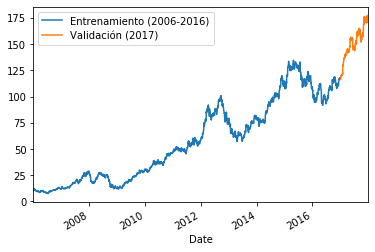

In [8]:
set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

In [9]:
time_step = 60
set_entrenamiento[-1*time_step:].shape

(60, 1)

In [10]:
set_entrenamiento[-1*time_step:].tail()

,High
Date,
2016-12-23,116.52
2016-12-27,117.80
2016-12-28,118.02
2016-12-29,117.11
2016-12-30,117.20


In [11]:
set_validacion.head()

,High
Date,
2017-01-03,116.33
2017-01-04,116.51
2017-01-05,116.86
2017-01-06,118.16
2017-01-09,119.43


In [12]:
set_validacion_init = set_validacion.copy()
index_validacion = set_validacion.index.copy()

set_validacion = pd.concat([
    set_entrenamiento[-1*time_step:], 
    set_validacion],
    axis=0
)
set_validacion.shape, set_validacion_init.shape

((311, 1), (251, 1))

In [13]:
#other_entrenamiento = dataset['2006':'2015'].iloc[:, 1:2]
#other_validacion = dataset['2016'].iloc[:, 1:2]

#print(other_entrenamiento.index.min(), other_entrenamiento.index.max(), other_entrenamiento.shape)
#print(other_validacion.index.min(), other_validacion.index.max(), other_validacion.shape)

In [14]:
#other_entrenamiento['High'].plot(legend=True)
#other_validacion['High'].plot(legend=True)
#plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
#plt.show()

## Modeling

In [15]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

display(set_entrenamiento_escalado)

set_entrenamiento_escalado.shape

array([[0.0245708 ],
       [0.02590959],
       [0.0247283 ],
       ...,
       [0.86990077],
       [0.86273429],
       [0.86344306]])

(2768, 1)

In [16]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [17]:
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step, m):
    X_train.append(
        set_entrenamiento_escalado[i - time_step: i, 0]
    )
    Y_train.append(
        set_entrenamiento_escalado[i, 0]
    )
    
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [18]:
X_train.shape, Y_train.shape

((2708, 60), (2708,))

In [19]:
display(X_train[0])
display("-"*100)
display(X_train[1])

array([0.0245708 , 0.02590959, 0.0247283 , 0.02677587, 0.02732714,
       0.03260356, 0.03583241, 0.03764372, 0.03724996, 0.03764372,
       0.03504489, 0.0323673 , 0.03047724, 0.03000473, 0.02984722,
       0.02764215, 0.02535832, 0.02323201, 0.02661837, 0.02638211,
       0.02646086, 0.02527957, 0.02236573, 0.02205072, 0.01866436,
       0.01819184, 0.01834935, 0.01661679, 0.01559301, 0.01708931,
       0.01882186, 0.02031816, 0.02023941, 0.0200819 , 0.02110569,
       0.02260198, 0.02244448, 0.0215782 , 0.02189321, 0.01866436,
       0.01921562, 0.01913687, 0.01661679, 0.01575051, 0.01606552,
       0.015278  , 0.01299417, 0.01504174, 0.01622303, 0.01701055,
       0.01575051, 0.01417546, 0.01409671, 0.01283667, 0.01165538,
       0.01008033, 0.00905654, 0.00952906, 0.00811151, 0.0107891 ])

'----------------------------------------------------------------------------------------------------'

array([0.02590959, 0.0247283 , 0.02677587, 0.02732714, 0.03260356,
       0.03583241, 0.03764372, 0.03724996, 0.03764372, 0.03504489,
       0.0323673 , 0.03047724, 0.03000473, 0.02984722, 0.02764215,
       0.02535832, 0.02323201, 0.02661837, 0.02638211, 0.02646086,
       0.02527957, 0.02236573, 0.02205072, 0.01866436, 0.01819184,
       0.01834935, 0.01661679, 0.01559301, 0.01708931, 0.01882186,
       0.02031816, 0.02023941, 0.0200819 , 0.02110569, 0.02260198,
       0.02244448, 0.0215782 , 0.02189321, 0.01866436, 0.01921562,
       0.01913687, 0.01661679, 0.01575051, 0.01606552, 0.015278  ,
       0.01299417, 0.01504174, 0.01622303, 0.01701055, 0.01575051,
       0.01417546, 0.01409671, 0.01283667, 0.01165538, 0.01008033,
       0.00905654, 0.00952906, 0.00811151, 0.0107891 , 0.01165538])

In [20]:
X_train = np.reshape(
    X_train, 
    (X_train.shape[0], X_train.shape[1], 1)
)

display(X_train[0])
display("-"*100)
display(X_train[1])

array([[0.0245708 ],
       [0.02590959],
       [0.0247283 ],
       [0.02677587],
       [0.02732714],
       [0.03260356],
       [0.03583241],
       [0.03764372],
       [0.03724996],
       [0.03764372],
       [0.03504489],
       [0.0323673 ],
       [0.03047724],
       [0.03000473],
       [0.02984722],
       [0.02764215],
       [0.02535832],
       [0.02323201],
       [0.02661837],
       [0.02638211],
       [0.02646086],
       [0.02527957],
       [0.02236573],
       [0.02205072],
       [0.01866436],
       [0.01819184],
       [0.01834935],
       [0.01661679],
       [0.01559301],
       [0.01708931],
       [0.01882186],
       [0.02031816],
       [0.02023941],
       [0.0200819 ],
       [0.02110569],
       [0.02260198],
       [0.02244448],
       [0.0215782 ],
       [0.02189321],
       [0.01866436],
       [0.01921562],
       [0.01913687],
       [0.01661679],
       [0.01575051],
       [0.01606552],
       [0.015278  ],
       [0.01299417],
       [0.015

'----------------------------------------------------------------------------------------------------'

array([[0.02590959],
       [0.0247283 ],
       [0.02677587],
       [0.02732714],
       [0.03260356],
       [0.03583241],
       [0.03764372],
       [0.03724996],
       [0.03764372],
       [0.03504489],
       [0.0323673 ],
       [0.03047724],
       [0.03000473],
       [0.02984722],
       [0.02764215],
       [0.02535832],
       [0.02323201],
       [0.02661837],
       [0.02638211],
       [0.02646086],
       [0.02527957],
       [0.02236573],
       [0.02205072],
       [0.01866436],
       [0.01819184],
       [0.01834935],
       [0.01661679],
       [0.01559301],
       [0.01708931],
       [0.01882186],
       [0.02031816],
       [0.02023941],
       [0.0200819 ],
       [0.02110569],
       [0.02260198],
       [0.02244448],
       [0.0215782 ],
       [0.02189321],
       [0.01866436],
       [0.01921562],
       [0.01913687],
       [0.01661679],
       [0.01575051],
       [0.01606552],
       [0.015278  ],
       [0.01299417],
       [0.01504174],
       [0.016

In [21]:
np.reshape(Y_train, (Y_train.shape[0], 1))

array([[0.01165538],
       [0.01204914],
       [0.01260041],
       ...,
       [0.86990077],
       [0.86273429],
       [0.86344306]])

In [22]:
Y_train

array([0.01165538, 0.01204914, 0.01260041, ..., 0.86990077, 0.86273429,
       0.86344306])

In [23]:
# Red LSTM
#
dim_entrada = (X_train.shape[1], 1)
dim_salida = 1
na = 50

In [24]:
modelo = Sequential()
modelo.add(
    LSTM(units=na, input_shape=dim_entrada)
)
modelo.add(
    Dense(units=dim_salida)
)
modelo.compile(
    optimizer='rmsprop', 
    loss='mse'
)
modelo.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    batch_size=32
)

Epoch 1/10
2708/2708 [==============================] - 4s 2ms/step - loss: 0.0096
Epoch 2/10
2708/2708 [==============================] - 3s 1ms/step - loss: 0.0012
Epoch 3/10
2708/2708 [==============================] - 3s 1ms/step - loss: 7.3717e-04
Epoch 4/10
2708/2708 [==============================] - 3s 1ms/step - loss: 5.3420e-04
Epoch 5/10
2708/2708 [==============================] - 3s 969us/step - loss: 4.0960e-04
Epoch 6/10
2708/2708 [==============================] - 3s 951us/step - loss: 3.6817e-04
Epoch 7/10
2708/2708 [==============================] - 2s 913us/step - loss: 3.2374e-04
Epoch 8/10
2708/2708 [==============================] - 2s 921us/step - loss: 3.0008e-04
Epoch 9/10
2708/2708 [==============================] - 2s 889us/step - loss: 2.5060e-04
Epoch 10/10
2708/2708 [==============================] - 3s 1ms/step - loss: 2.6070e-04


In [25]:
set_validacion.shape

(311, 1)

In [26]:
#
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)
x_test.shape

(311, 1)

In [27]:
display(set_validacion.head(2))
display(set_validacion.tail(2))

,High
Date,
2016-10-06,114.34
2016-10-07,114.56


,High
Date,
2017-12-28,171.85
2017-12-29,170.59


In [28]:
X_test = []

for i in range(time_step, len(x_test)):
    X_test.append( 
        x_test[i - time_step:i, 0]
    )

In [29]:
X_test = np.array(X_test)
X_test

array([[0.84091983, 0.84265239, 0.8598992 , ..., 0.86990077, 0.86273429,
        0.86344306],
       [0.84265239, 0.8598992 , 0.87517719, ..., 0.86273429, 0.86344306,
        0.85659159],
       [0.8598992 , 0.87517719, 0.86958576, ..., 0.86344306, 0.85659159,
        0.85800914],
       ...,
       [1.15679635, 1.16183651, 1.15214994, ..., 1.32666562, 1.32194046,
        1.2908332 ],
       [1.16183651, 1.15214994, 1.16459285, ..., 1.32194046, 1.2908332 ,
        1.28539928],
       [1.15214994, 1.16459285, 1.16498661, ..., 1.2908332 , 1.28539928,
        1.2938258 ]])

In [30]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test

array([[[0.84091983],
        [0.84265239],
        [0.8598992 ],
        ...,
        [0.86990077],
        [0.86273429],
        [0.86344306]],

       [[0.84265239],
        [0.8598992 ],
        [0.87517719],
        ...,
        [0.86273429],
        [0.86344306],
        [0.85659159]],

       [[0.8598992 ],
        [0.87517719],
        [0.86958576],
        ...,
        [0.86344306],
        [0.85659159],
        [0.85800914]],

       ...,

       [[1.15679635],
        [1.16183651],
        [1.15214994],
        ...,
        [1.32666562],
        [1.32194046],
        [1.2908332 ]],

       [[1.16183651],
        [1.15214994],
        [1.16459285],
        ...,
        [1.32194046],
        [1.2908332 ],
        [1.28539928]],

       [[1.15214994],
        [1.16459285],
        [1.16498661],
        ...,
        [1.2908332 ],
        [1.28539928],
        [1.2938258 ]]])

In [31]:
X_test.shape

(251, 60, 1)

In [32]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

In [33]:
set_validacion_init.shape

(251, 1)

In [34]:
set_validacion.values.shape, prediccion.shape

((311, 1), (251, 1))

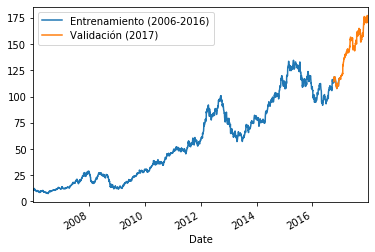

In [35]:
set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

In [36]:
prediccion_series = pd.Series(
    prediccion[:, 0],
    index=index_validacion
)
display(prediccion_series.head())
display(set_validacion_init['High'].head())

Date
2017-01-03    119.015999
2017-01-04    118.582077
2017-01-05    118.220375
2017-01-06    118.132507
2017-01-09    118.635109
dtype: float32

Date
2017-01-03    116.33
2017-01-04    116.51
2017-01-05    116.86
2017-01-06    118.16
2017-01-09    119.43
Name: High, dtype: float64

In [37]:
type(prediccion_series),  type(set_validacion_init)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

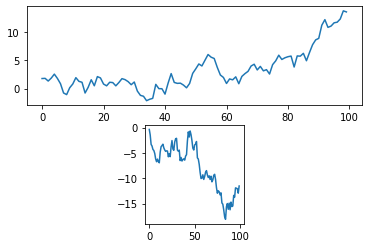

In [38]:
fig, axs = plt.subplots(2,1)

axs[0].plot(np.random.randn(100).cumsum())
axs[1].plot(np.random.randn(100).cumsum())

aspect = np.diff(axs[1].get_xlim()) / np.diff(axs[1].get_ylim())
axs[1].set_aspect(aspect)

In [39]:
#help(plt.plot)

In [40]:
set_entrenamiento.index[10]

Timestamp('2006-01-18 00:00:00')

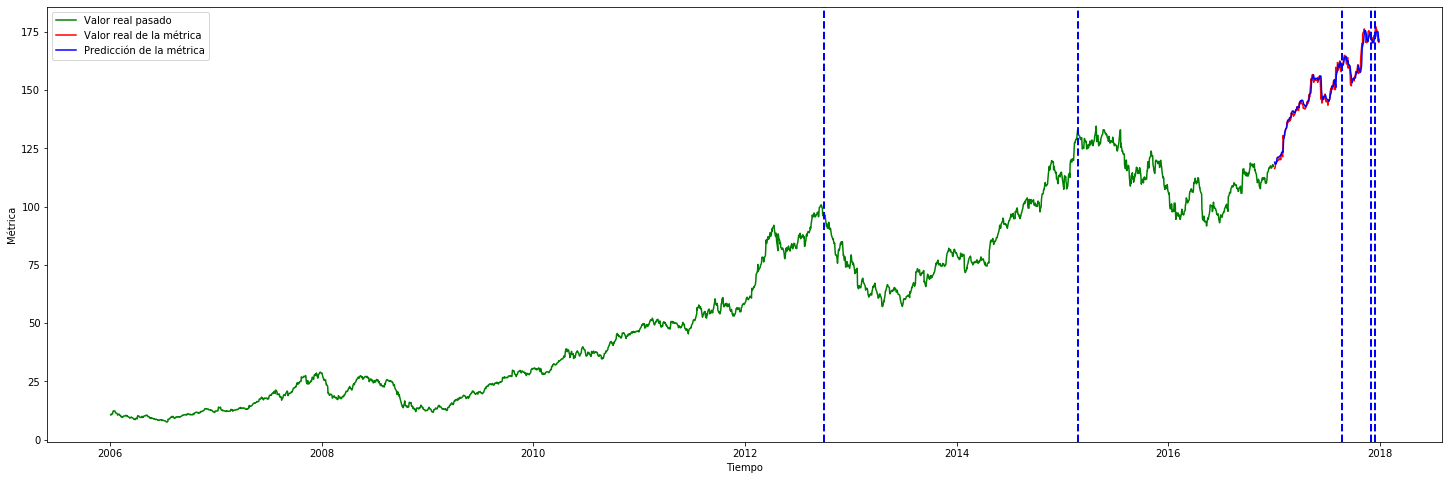

In [41]:
# Graficar resultados
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 8))

axes.plot(set_entrenamiento['High'], color='green', label='Valor real pasado')
plt.plot(set_validacion_init['High'], color='red', label='Valor real de la métrica')
plt.plot(prediccion_series, color='blue', label='Predicción de la métrica')


axes.axvline(set_entrenamiento.index[1698], color="blue", linestyle="--", lw=2)
axes.axvline(set_entrenamiento.index[2300], color="blue", linestyle="--", lw=2)

axes.axvline(set_validacion_init.index[160], color="blue", linestyle="--", lw=2)
axes.axvline(set_validacion_init.index[230], color="blue", linestyle="--", lw=2)
axes.axvline(set_validacion_init.index[240], color="blue", linestyle="--", lw=2)

#plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))

plt.xlabel('Tiempo')
plt.ylabel('Métrica')
plt.legend()
plt.show()